In [1]:
using Flux
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate
using MultivariateStats
using PyPlot

push!(LOAD_PATH, pwd(), "/home/jan/dev/anomaly detection/anomaly_detection/src", "/home/jan/dev/FluxExtensions.jl/src")
using KNNmem
using AnomalyDetection

dataPath = "/home/jan/dev/data/loda/public/datasets/numerical"
allData = AnomalyDetection.loaddata(dataPath)


Dict{String,AnomalyDetection.Basicset} with 38 entries:
  "breast-cancer-wisconsin" => AnomalyDetection.Basicset([13.54 13.08 … 11.2 7.…
  "miniboone"               => AnomalyDetection.Basicset([4.87844 6.45217 … 5.4…
  "haberman"                => AnomalyDetection.Basicset([30.0 30.0 … 76.0 77.0…
  "blood-transfusion"       => AnomalyDetection.Basicset([1.0 4.0 … 39.0 72.0; …
  "ecoli"                   => AnomalyDetection.Basicset([0.49 0.07 … 0.67 0.68…
  "madelon"                 => AnomalyDetection.Basicset([485.0 483.0 … 475.0 4…
  "statlog-satimage"        => AnomalyDetection.Basicset([92.0 84.0 … 60.0 64.0…
  "parkinsons"              => AnomalyDetection.Basicset([119.992 122.4 … 148.4…
  "abalone"                 => AnomalyDetection.Basicset([0.0 0.0 … 1.0 0.0; 0.…
  "iris"                    => AnomalyDetection.Basicset([5.1 4.9 … 6.2 5.9; 3.…
  "yeast"                   => AnomalyDetection.Basicset([0.58 0.43 … 0.47 0.43…
  "pendigits"               => AnomalyDetection.Basic

In [2]:
dataset = allData["pendigits"]
train, test, clusterdness = AnomalyDetection.makeset(dataset, 0.8, "medium", 0.05, "high")

(AnomalyDetection.Dataset([2.05114 0.234676 … 1.88896 -1.12767; 0.0410319 0.115369 … 0.338381 -2.48644; … ; 1.40273 -0.996487 … -0.996487 0.229202; 2.06894 -0.398872 … -0.367234 -0.778536], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), AnomalyDetection.Dataset([-1.12767 1.79165 … 2.11602 -1.12767; 0.784406 -1.29704 … 0.858743 0.858743; … ; -0.42276 -0.996487 … -0.996487 1.61136; -0.778536 -0.778536 … -0.778536 -0.778536], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 0.9375899098731115)

In [3]:
dataPCA = fit(PCA, train.data; maxoutdim = 3)


PCA(indim = 16, outdim = 3, principalratio = 0.67068)

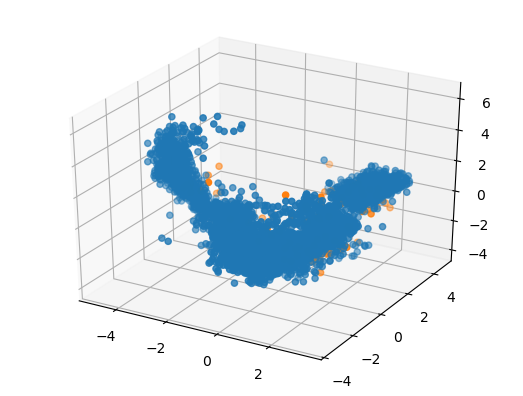

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x7f816ee78cc0>

In [4]:
projectedData = transform(dataPCA, train.data)

backgroundIndeces = train.labels .== 0
anomalyIndeces = train.labels .== 1

scatter3D(projectedData[1,backgroundIndeces], projectedData[2,backgroundIndeces], projectedData[3,backgroundIndeces])
scatter3D(projectedData[1,anomalyIndeces], projectedData[2,anomalyIndeces], projectedData[3,anomalyIndeces])


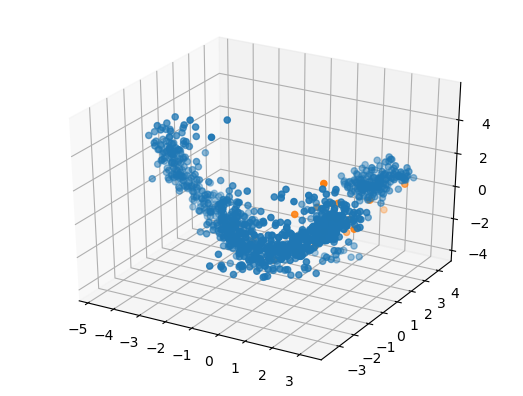

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x7f816e04db70>

In [5]:
projectedData = transform(dataPCA, test.data)

backgroundIndeces = test.labels .== 0
anomalyIndeces = test.labels .== 1

scatter3D(projectedData[1,backgroundIndeces], projectedData[2,backgroundIndeces], projectedData[3,backgroundIndeces])
scatter3D(projectedData[1,anomalyIndeces], projectedData[2,anomalyIndeces], projectedData[3,anomalyIndeces])


In [11]:
inputSize = size(train.data, 1)
zSize = 10 # size of the encoding vector
memorySize = 100 # size of the kNN memory
k = 16 # number of the nearest neighbors in the kNN
β = 1. # parameter setting the weight of the memory loss

# RELU could easily create a zero vector which creates problems in the memory
# as the memory demands vectors with a norm = 1 and normalizes the others
encoder = Dense(inputSize, zSize, tanh)
decoder = Dense(zSize, inputSize, tanh)
model = Chain(encoder, decoder)

memory = KNNmemory(memorySize, zSize, k, 2)

reconstructionError(x) = Flux.mse(model(x), x)
loss(x, y) = reconstructionError(x) + β * trainQuery!(memory, encoder(x), y)
opt = ADAM(params(model))

(::#71) (generic function with 1 method)

In [ ]:
iterations = 5000
batchSize = 1000

for i in 1:iterations
    # sample from data
    batchIndeces = rand(1:size(train.data, 2),batchSize)
    x = train.data[:, batchIndeces]
    y = train.labels[batchIndeces]

    # gradient computation and update
    l = loss(x, y)
    if i % 100 == 0
        print(l)
        println(" $(reconstructionError(x))")
    end
    Flux.Tracker.back!(l)
    opt()
end

println("Reconstruction err: $(reconstructionError(test.data))")

rocData = roc(test.labels, query(memory, encoder(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")